### Coursera Machine Learning Foundation
#### Section 2, Part c: Cross Validation

In [1]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [2]:
path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/data/boston_housing_clean.pickle"
 
 
# Import pandas library
import pandas as pd
 
# Read the online file by the URL provides above, and assign it to variable "df"
 
boston = pickle.load(open('boston_housing_clean.pickle', "rb" ))

In [3]:
boston.keys()

dict_keys(['dataframe', 'description'])

In [4]:
boston_data = boston['dataframe']
boston_description = boston['description']

In [5]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#### Discussion:
Suppose we want to do Linear Regression on our dataset to get an estimate, based on mean squared error, of how well our model will perform on data outside our dataset.

Suppose also that our data is split into three folds: Fold 1, Fold 2, and Fold 3.

#### Coding this up
The KFold object in SciKit Learn tells the cross validation object (see below) how to split up the data:

In [6]:
X = boston_data.drop('MEDV', axis=1)
y = boston_data.MEDV

In [7]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [8]:
for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:",test_index[:10], len(test_index))
    print('')

Train index: [ 1  3  4  5  7  8 10 11 12 13] 337
Test index: [ 0  2  6  9 15 17 19 23 25 26] 169

Train index: [ 0  2  6  9 10 11 12 13 15 17] 337
Test index: [ 1  3  4  5  7  8 14 16 22 27] 169

Train index: [0 1 2 3 4 5 6 7 8 9] 338
Test index: [10 11 12 13 18 20 21 24 28 31] 168



In [9]:
#from sklearn.metrics import r2_score, mean_squared_error

scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
scores

[0.671934879847282, 0.7485020059212362, 0.6976807323597747]

#### Discussion (Part 2):
Now suppose we want to do the same, but appropriately scaling our data as we go through the folds.

In [11]:
scores = []

lr = LinearRegression()
s = StandardScaler()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    X_train_s = s.fit_transform(X_train)
    
    lr.fit(X_train_s, y_train)
    
    X_test_s = s.transform(X_test)
    
    y_pred = lr.predict(X_test_s)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)
scores

[0.6719348798472715, 0.748502005921238, 0.6976807323597747]

same scores, because for vanilla linear regression with no regularization, scaling actually doesn't matter for performance)

This is getting quite cumbersome!

Very luckily, SciKit Learn has some wonderful functions that handle a lot of this for us.

#### Pipeline and cross_val_predict
Pipeline lets you chain together multiple operators on your data that both have a fit method.

In [12]:
estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

#### cross_val_predict
cross_val_predict is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

In [13]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

In [14]:
predictions = cross_val_predict(estimator, X, y, cv=kf)

In [15]:
r2_score(y, predictions)

0.7063531064161561

In [16]:
np.mean(scores) # almost identical!

0.7060392060427615

Note that cross_val_predict doesn't use the same model for all steps; the predictions for each row are made when that row is in the validation set. We really have the collected results of 3 (i.e. kf.num_splits) different models.

When we are done, estimator is still not fitted. If we want to predict on new data, we still have to train our estimator.

#### Hyperparameter tuning
##### Definition
Hyperparameter tuning involves using cross validation (or train-test split) to determine which hyperparameters are most likely to generate a model that generalizes well outside of your sample.

#### Mechanics
We can generate an exponentially spaces range of values using the numpy geomspace function.

np.geomspace(1, 1000, num=4)
produces:

array([    1.,    10.,   100.,  1000.])      
Use this function to generate a list of length 10 called alphas for hyperparameter tuning:

In [17]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

In [18]:
scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

In [19]:
list(zip(alphas,scores))

[(1e-09, 0.7063531064981925),
 (1e-08, 0.7063531072356071),
 (1e-07, 0.7063531145602442),
 (1e-06, 0.7063531882052065),
 (1e-05, 0.7063539165191507),
 (0.0001, 0.706361268093463),
 (0.001, 0.706433467041546),
 (0.01, 0.7070865958083233),
 (0.1, 0.705838151167185),
 (1.0, 0.6512724532884888)]

In [20]:
Lasso(alpha=1e-6).fit(X, y).coef_

array([-1.07170372e-01,  4.63952623e-02,  2.08588308e-02,  2.68854318e+00,
       -1.77954207e+01,  3.80475296e+00,  7.50802707e-04, -1.47575348e+00,
        3.05654279e-01, -1.23293755e-02, -9.53459908e-01,  9.39253013e-03,
       -5.25467196e-01])

In [21]:
Lasso(alpha=1.0).fit(X, y).coef_

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

#### Exercise
Add PolynomialFeatures to this Pipeline, and re-run the cross validation with the PolynomialFeatures added.

Hint #1: pipelines process input from first to last. Think about the order that it would make sense to add Polynomial Features to the data in sequence and add them in the appropriate place in the pipeline.

Hint #2: you should see a significant increase in cross validation accuracy from doing this

In [22]:
pf = PolynomialFeatures(degree=3)

scores = []
alphas = np.geomspace(0.06, 6.0, 20)
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)
    

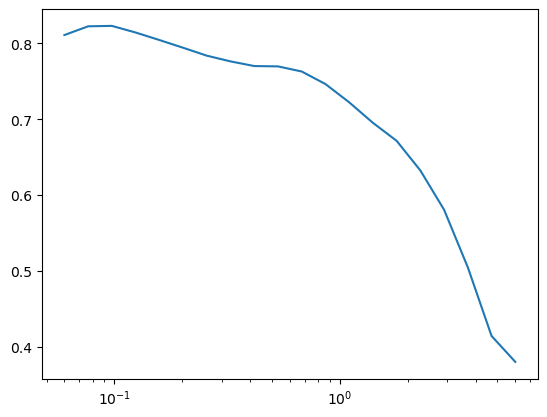

In [23]:
plt.semilogx(alphas, scores);

In [24]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.9134777735196521

In [27]:
best_estimator.named_steps["lasso_regression"].coef_

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -1.00309168e+00,  3.32679107e+00, -1.01840878e+00,
       -2.56161421e+00,  1.12778302e+00, -1.72266155e+00, -5.37088506e-01,
        4.39555878e-01, -3.39542586e+00,  7.22387712e-02,  0.00000000e+00,
        0.00000000e+00,  3.53653554e+00, -0.00000000e+00,  3.72285440e-01,
        0.00000000e+00,  0.00000000e+00, -5.49528703e-01, -0.00000000e+00,
       -0.00000000e+00, -4.05522485e-02,  2.25864611e-01,  1.78508858e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.50874606e-02,
       -0.00000000e+00, -2.07295802e-01, -0.00000000e+00,  3.71781995e-01,
        0.00000000e+00, -0.00000000e+00, -5.89531100e-02,  3.47180625e-01,
        0.00000000e+00,  9.23666274e-01,  3.48873365e-01,  7.29463442e-02,
        0.00000000e+00,  0.00000000e+00,  7.68485586e-02, -7.21083596e-01,
        0.00000000e+00, -5.98542558e-01,  4.18420677e-01, -7.98165728e-01,
       -7.25062683e-01,  

#### Exercise
Do the same, but with Ridge regression

Which model, Ridge or Lasso, performs best with its optimal hyperparameters on the Boston dataset?

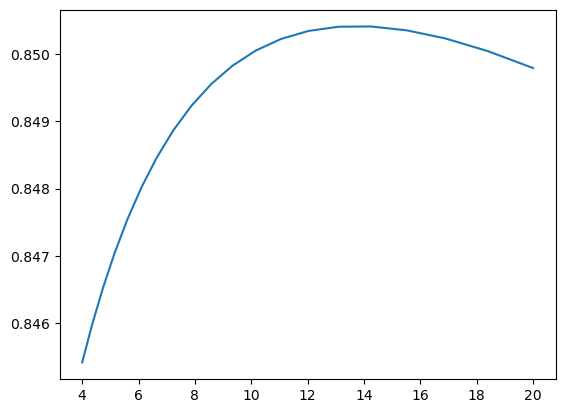

In [28]:
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(4, 20, 20)
scores=[]
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    score = r2_score(y, predictions)
    scores.append(score)

plt.plot(alphas, scores)

In [29]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.9134777735196521

In [30]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names_out(),
                 best_estimator.named_steps["lasso_regression"].coef_,
))

In [31]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))

In [32]:
col_names_dict

{0: 'CRIM',
 1: 'ZN',
 2: 'INDUS',
 3: 'CHAS',
 4: 'NOX',
 5: 'RM',
 6: 'AGE',
 7: 'DIS',
 8: 'RAD',
 9: 'TAX',
 10: 'PTRATIO',
 11: 'B',
 12: 'LSTAT'}

In [34]:
df_importances.sort_values(by=1)

,0,1
13,x12,-3.395426
8,x7,-2.561614
10,x9,-1.722662
94,x8 x12,-1.124408
72,x5 x8,-1.085987
...,...,...
9,x8,1.127783
79,x6 x8,1.363407
96,x9 x10,1.962870
6,x5,3.326791


#### Grid Search CV
To do cross-validation, we used two techniques:

use KFolds and manually create a loop to do cross-validation
use cross_val_predict and score to get a cross-valiated score in a couple of lines.
To do hyper-parameter tuning, we see a general pattern:

use cross_val_predict and score in a manually written loop over hyperparemeters, then select the best one.
Perhaps not surprisingly, there is a function that does this for us -- GridSearchCV

In [35]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 20)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [36]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.3535936 ,  4.73844431,  5.15731521,  5.61321363,
        6.10941274,  6.64947505,  7.23727802,  7.87704182,  8.57335972,
        9.331231  , 10.1560969 , 11.05387963, 12.03102491, 13.09454827,
       14.25208539, 15.51194695, 16.88317825, 18.37562421, 20.        ])})

In [37]:
grid.best_score_, grid.best_params_

(0.8504992740007822,
 {'polynomial_features__degree': 2,
  'ridge_regression__alpha': 15.511946948525646})

In [38]:
y_predict = grid.predict(X)

In [39]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict)

0.9146985287463713

In [40]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00, -1.28829772e-01, -5.05856284e-03,  1.62658971e-02,
        1.00085587e-01, -9.67012834e-01,  3.25919745e+00, -9.57354081e-01,
       -1.94774304e+00,  8.47932375e-01, -1.00903101e+00, -7.09489284e-01,
        5.48320825e-01, -3.02796163e+00,  7.69588769e-02,  7.24274286e-02,
        6.75359501e-02,  1.70458885e+00, -4.76779943e-01,  5.72065384e-01,
        1.29769211e-01,  2.25908428e-01, -7.39176477e-01,  1.64401016e-01,
       -7.79048916e-02, -8.46238751e-02,  4.98683957e-01,  2.15472338e-01,
       -1.47172451e-01,  1.44110784e-01,  1.95181246e-01,  5.12046833e-02,
       -1.10854296e-01, -2.73868352e-01, -1.31082729e-01,  7.19564832e-01,
        5.48148586e-02,  8.81408420e-02, -2.65489851e-01,  5.80545185e-01,
        1.07454993e-01,  9.49069101e-01,  5.68679067e-01,  5.32690017e-01,
        6.98752649e-01, -5.91389648e-02,  7.43093700e-02, -4.26375257e-01,
        2.35823244e-01, -6.82554161e-01,  3.39870567e-01, -9.60949439e-01,
       -8.12827100e-01,  

In [44]:
grid.cv_results_


{'mean_fit_time': array([0.00766206, 0.00566332, 0.00632874, 0.005663  , 0.00666253,
        0.00566451, 0.00532985, 0.00599575, 0.00599639, 0.0053304 ,
        0.00566316, 0.00533048, 0.0063285 , 0.00599591, 0.00599631,
        0.0049994 , 0.00599631, 0.00566125, 0.005663  , 0.00616606,
        0.00699488, 0.0073336 , 0.00766619, 0.00766158, 0.00763655,
        0.00721391, 0.00832971, 0.00799513, 0.00866175, 0.00766277,
        0.00763011, 0.00766063, 0.00899458, 0.00799561, 0.00866048,
        0.0076619 , 0.00732875, 0.00655421, 0.00690436, 0.00724244,
        0.01563247, 0.01365757, 0.01232616, 0.01632396, 0.01265979,
        0.01365876, 0.01465821, 0.01599121, 0.01265907, 0.01499343,
        0.01499073, 0.0128301 , 0.01526109, 0.01432403, 0.0123268 ,
        0.01532316, 0.01332625, 0.01399175, 0.01499128, 0.01632293]),
 'std_fit_time': array([9.43246876e-04, 4.71145933e-04, 4.71426801e-04, 4.71258002e-04,
        4.71145571e-04, 4.69459858e-04, 4.71201776e-04, 5.84003864e-07,
     

In [45]:
# result in dataframe

pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomial_features__degree,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007662,9.432469e-04,0.003664,1.698288e-03,1,4.000000,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672111,0.748235,0.701801,0.707382,0.031327,40
1,0.005663,4.711459e-04,0.003331,4.710332e-04,1,4.353594,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672098,0.748191,0.702086,0.707458,0.031296,39
2,0.006329,4.714268e-04,0.002333,4.705286e-04,1,4.738444,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672080,0.748139,0.702386,0.707535,0.031264,38
3,0.005663,4.712580e-04,0.003019,2.922181e-05,1,5.157315,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672057,0.748081,0.702699,0.707612,0.031230,37
4,0.006663,4.711456e-04,0.002026,3.781990e-05,1,5.613214,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672027,0.748013,0.703025,0.707689,0.031196,36
5,0.005665,4.694599e-04,0.003331,4.712580e-04,1,6.109413,"{'polynomial_features__degree': 1, 'ridge_regr...",0.671990,0.747935,0.703365,0.707763,0.031160,35
6,0.005330,4.712018e-04,0.003000,4.673383e-06,1,6.649475,"{'polynomial_features__degree': 1, 'ridge_regr...",0.671945,0.747846,0.703716,0.707836,0.031123,33
7,0.005996,5.840039e-07,0.002665,4.715955e-04,1,7.237278,"{'polynomial_features__degree': 1, 'ridge_regr...",0.671889,0.747744,0.704079,0.707904,0.031085,32
8,0.005996,1.173403e-06,0.002664,4.720451e-04,1,7.877042,"{'polynomial_features__degree': 1, 'ridge_regr...",0.671824,0.747628,0.704452,0.707968,0.031047,30
9,0.005330,4.713142e-04,0.002997,8.150748e-04,1,8.573360,"{'polynomial_features__degree': 1, 'ridge_regr...",0.671746,0.747495,0.704834,0.708025,0.031007,28


#### Summary
We can manually generate folds by using KFolds
We can get a score using cross_val_predict(X, y, cv=KFoldObject_or_integer). This will produce the out-of-bag prediction for each row.
When doing hyperparameter selection, we should be optimizing on out-of-bag scores. This means either using cross_val_predict in a loop, or ....
.... use GridSearchCV. GridSearchCV takes a model (or pipeline) and a dictionary of parameters to scan over. It finds the hyperparameter set that has the best out-of-sample score on all the parameters, and calls that it's "best estimator". It then retrains on all data with the "best" hyper-parameters.

#### Extensions
Here are some additional items to keep in mind:

There is a RandomSearchCV that tries random combination of model parameters. This can be helpful if you have a prohibitive number of combinations to test them all exhaustively.
KFolds will randomly select rows to be in the training and test folds. There are other methods (such as StratifiedKFolds and GroupKFold, which are useful when you need more control over how the data is split (e.g. to prevent data leakage). You can create these specialized objects and pass them to the cv argument of GridSearchCV.
